In [0]:
# !git clone https://github.com/NVIDIA/apex # For fp16
# !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

In [2]:
!pip install transformers
!python -m spacy download en
!pip install tensorboardX

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [3]:
# !fusermount -u drive
# !google-drive-ocamlfuse drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import os, re, time
from collections import Counter
from os.path import join as joinpath
from tqdm import tqdm
tqdm.pandas()

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline

os.getcwd()

'/content'

In [5]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          13022         582        5583           0        6856       12162
Swap:             0           0           0


In [6]:
try:
  os.chdir('drive/My Drive/Colab Notebooks/crowdflower-search-relevance')
  print('Changed directory')
  print(os.getcwd())
except:
  print('Cannot change directory')
  print(os.getcwd())
  
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using:', device)

Changed directory
/content/drive/My Drive/Colab Notebooks/crowdflower-search-relevance
Using: cuda


In [7]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_train.head()

,id,query,product_title,product_description,median_relevance,relevance_variance
0,1,bridal shower decorations,Accent Pillow with Heart Design - Red/Black,Red satin accent pillow embroidered with a hea...,1,0.000
1,2,led christmas lights,Set of 10 Battery Operated Multi LED Train Chr...,Set of 10 Battery Operated Train Christmas Lig...,4,0.000
2,4,projector,ViewSonic Pro8200 DLP Multimedia Projector,NaN,4,0.471
3,5,wine rack,Concept Housewares WR-44526 Solid-Wood Ceiling...,"Like a silent and sturdy tree, the Southern En...",4,0.000
4,7,light bulb,Wintergreen Lighting Christmas LED Light Bulb ...,"WTGR1011\nFeatures\nNickel base, 60,000 averag...",2,0.471


In [8]:
print(len(df_train))
print(len(df_test))

10158
22513


In [9]:
df_train.isna().sum()

id                        0
query                     0
product_title             0
product_description    2444
median_relevance          0
relevance_variance        0
dtype: int64

In [10]:
df_test.isna().sum()

id                        0
query                     0
product_title             0
product_description    5427
dtype: int64

In [11]:
Counter(df_train.median_relevance)

Counter({1: 774, 2: 1476, 3: 1737, 4: 6171})

In [12]:
# df_train = df_train.dropna()
# df_test = df_test.dropna()
# print(len(df_train))
# print(len(df_test))

df_train.fillna('', inplace=True)
df_test.fillna('', inplace=True)
df_train.head()

,id,query,product_title,product_description,median_relevance,relevance_variance
0,1,bridal shower decorations,Accent Pillow with Heart Design - Red/Black,Red satin accent pillow embroidered with a hea...,1,0.000
1,2,led christmas lights,Set of 10 Battery Operated Multi LED Train Chr...,Set of 10 Battery Operated Train Christmas Lig...,4,0.000
2,4,projector,ViewSonic Pro8200 DLP Multimedia Projector,,4,0.471
3,5,wine rack,Concept Housewares WR-44526 Solid-Wood Ceiling...,"Like a silent and sturdy tree, the Southern En...",4,0.000
4,7,light bulb,Wintergreen Lighting Christmas LED Light Bulb ...,"WTGR1011\nFeatures\nNickel base, 60,000 averag...",2,0.471


In [13]:
Counter(df_train.median_relevance)

Counter({1: 774, 2: 1476, 3: 1737, 4: 6171})

In [0]:
def remove_numbers(val):
    m = re.findall(r'([A-Za-z]\w+)', val, flags=re.I)
    return ' '.join(m)

# stemmer = PorterStemmer()

def text_cleaner(x, append):
  x = BeautifulSoup(x).get_text(" ")
  x = re.sub("[^a-zA-Z0-9]", " ", x)
  # x = ' '.join([stemmer.stem(w) for w in x.split()])
  if append:
    return ' '.join([append+w for w in x.split()])
  else:
    return x

In [15]:
for col in ['query', 'product_title', 'product_description']:
  if col == 'query':
    append = None
  elif col == 'product_title':
    append = None
  elif col == 'product_description':
    append = None
  df_train[col] = df_train[col].progress_apply(lambda x: text_cleaner(x, append))
  df_test[col] = df_test[col].progress_apply(lambda x: text_cleaner(x, append))

df_train.head()

 27%|██▋       | 2692/10158 [00:00<00:02, 3293.00it/s]/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://i104.photobucket.com/albums/m175/champions_on_display/wincraft2013/januaryb/65497012.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
 33%|███▎      | 3356/10158 [00:01<00:02, 3311.35it/s]/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://i104.photobucket.com/albums/m175/champions_on_display/wincraft2013/januaryb/65516012.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
 96%|█████████▋| 9779/10158 [00:02<00:00, 3347.67it/s]/usr/local/l

,id,query,product_title,product_description,median_relevance,relevance_variance
0,1,bridal shower decorations,Accent Pillow with Heart Design Red Black,Red satin accent pillow embroidered with a hea...,1,0.000
1,2,led christmas lights,Set of 10 Battery Operated Multi LED Train Chr...,Set of 10 Battery Operated Train Christmas Lig...,4,0.000
2,4,projector,ViewSonic Pro8200 DLP Multimedia Projector,,4,0.471
3,5,wine rack,Concept Housewares WR 44526 Solid Wood Ceiling...,Like a silent and sturdy tree the Southern En...,4,0.000
4,7,light bulb,Wintergreen Lighting Christmas LED Light Bulb ...,WTGR1011 Features Nickel base 60 000 average ...,2,0.471


In [16]:
df_negative = df_train.copy()
df_negative['query'] = np.random.permutation(df_train['query'].values)
df_negative['median_relevance'] = 1
df_negative = df_negative.sample(frac=0.2)
df_negative.head()

,id,query,product_title,product_description,median_relevance,relevance_variance
7298,23564,hollister polo,Martha Stewart Fine Glitter 3 Pkg Desert,ek success martha stewart glitter and glue set...,1,0.471
130,399,crocs,Wellograph Watch and Fitness Monitor Smartwatc...,DISPLAY 1 26in Low Power LCD Integrated Bac...,1,0.000
8248,26575,microwave,NCAA Arkansas State Red Wolves Ultimate Hand,,1,0.000
4222,13688,gold toe socks,The Nuttery Roundhaus Squirrel Resistant Compa...,About this item Attractive round shape in lime...,1,0.000
3886,12508,kitchenaid mixer,Palmer s Cocoa Butter Men s Lotion 13 5 oz,Made with vitamin E Ideal for everyday use Abs...,1,0.471


In [17]:
df_train = pd.concat([df_train, df_negative], ignore_index=True, sort=False)
df_train.shape

(12190, 6)

14.928547990155865
2.4210828547990157


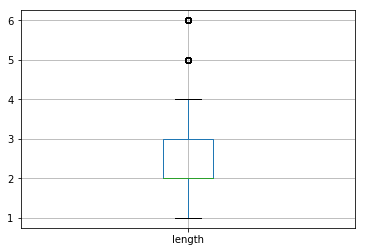

In [18]:
col = 'query'
print(df_train[col].str.len().mean())
df_train['length'] = df_train[col].apply(lambda x: len(x.split()))
print(df_train['length'].mean())
df_train.boxplot(column=['length'])

54.11304347826087
8.982936833470058


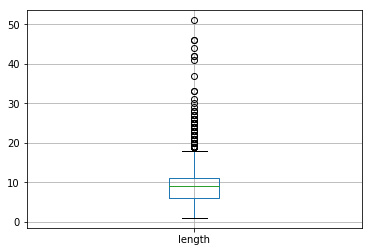

In [19]:
col = 'product_title'
print(df_train[col].str.len().mean())
df_train['length'] = df_train[col].apply(lambda x: len(x.split()))
print(df_train['length'].mean())
df_train.boxplot(column=['length'])

387.5940935192781
63.69360131255127


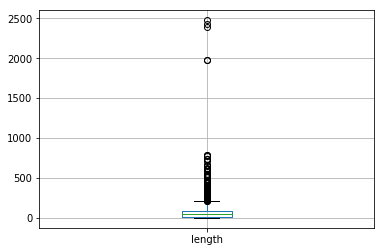

In [20]:
col = 'product_description'
print(df_train[col].str.len().mean())
df_train['length'] = df_train[col].apply(lambda x: len(x.split()))
print(df_train['length'].mean())
df_train.boxplot(column=['length'])

In [21]:
df_train['product_title'] = df_train[['product_title', 'product_description']].apply(lambda x: ' '.join(x), axis=1)
df_test['product_title'] = df_test[['product_title', 'product_description']].apply(lambda x: ' '.join(x), axis=1)
# df_train['query'] = df_train[['query', 'product_title']].apply(lambda x: ' [SEP] '.join(x), axis=1)
# df_test['query'] = df_test[['query', 'product_title']].apply(lambda x: ' [SEP] '.join(x), axis=1)

df_train.head()

,id,query,product_title,product_description,median_relevance,relevance_variance,length
0,1,bridal shower decorations,Accent Pillow with Heart Design Red Black Re...,Red satin accent pillow embroidered with a hea...,1,0.000,14
1,2,led christmas lights,Set of 10 Battery Operated Multi LED Train Chr...,Set of 10 Battery Operated Train Christmas Lig...,4,0.000,159
2,4,projector,ViewSonic Pro8200 DLP Multimedia Projector,,4,0.471,0
3,5,wine rack,Concept Housewares WR 44526 Solid Wood Ceiling...,Like a silent and sturdy tree the Southern En...,4,0.000,125
4,7,light bulb,Wintergreen Lighting Christmas LED Light Bulb ...,WTGR1011 Features Nickel base 60 000 average ...,2,0.471,46


In [0]:
# df_train['median_relevance'] = df_train['median_relevance']/4

442.70713699753895
72.67653814602133


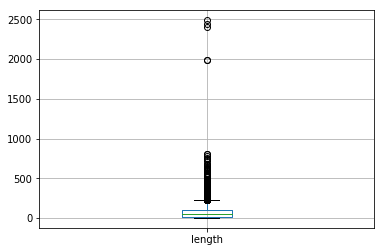

In [23]:
col = 'product_title'
print(df_train[col].str.len().mean())
df_train['length'] = df_train[col].apply(lambda x: len(x.split()))
print(df_train['length'].mean())
df_train.boxplot(column=['length'])

In [24]:
df_train[df_train.length<2]

,id,query,product_title,product_description,median_relevance,relevance_variance,length


In [25]:
df = df_train.sample(frac=1)
df_train.shape

(12190, 7)

In [0]:
output_directory = 'data'

x_col_names = ['id', 'query', 'product_title', 'product_description']
y_col_name = 'median_relevance'

from os.path import join as joinpath
import pandas as pd
from sklearn.model_selection import train_test_split


def split_save_df(df, x_col_names, y_col_name, output_directory, test_size=0.1, method='random', output_format='csv', train_name='train.csv', test_name='test.csv', random_state=0):
    '''
    method
    random: Splits randomly in stratifies manner
    first_n: Splits by first n rows. Needed when we want to use first n rows for train and rest for test.
    '''
    df = df[[*x_col_names, y_col_name]]
    if method == 'random':
        df_train, df_test = train_test_split(df, stratify=df[[y_col_name]], test_size=test_size, random_state=random_state)
    elif method == 'first_n':
        train_length = int(len(df) * (1 - test_size))
        df_train, df_test = df[:train_length], df[train_length:]
    if output_format == 'csv':
      df_train.to_csv(joinpath(output_directory, train_name), index=False)
      df_test.to_csv(joinpath(output_directory, test_name), index=False)
    elif output_format == 'tsv':
      df_train.to_csv(joinpath(output_directory, train_name), sep='\t', index=False)
      df_test.to_csv(joinpath(output_directory, test_name), sep='\t', index=False)

split_save_df(df, x_col_names=x_col_names, y_col_name=y_col_name,
              output_directory=output_directory, output_format='tsv',
              test_size=0.1, method='random', 
              train_name='train.tsv', test_name='dev.tsv')

df_test = df_test[x_col_names]
df_test.to_csv(joinpath(output_directory, 'test.tsv'), sep='\t', index=False)
time.sleep(10)

In [0]:
# --do_lower_case --fp16 

In [28]:
pd.read_csv('data/train.tsv', sep='\t').shape

(10971, 5)

In [29]:
!python run_glue.py --task_name crowdflower --model_type bert --model_name_or_path bert-base-uncased --do_lower_case --data_dir data --output_dir models --max_seq_length 64 --per_gpu_train_batch_size 8 --per_gpu_eval_batch_size 32 --num_train_epochs 2 --save_steps 5000 --do_train --do_eval --overwrite_output_dir

10/15/2019 03:49:56 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
10/15/2019 03:49:57 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
10/15/2019 03:49:57 - INFO - transformers.configuration_utils -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "crowdflower",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 4,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": tru

In [30]:
time.sleep(10)
!python predict.py --task_name crowdflower --model_type bert --model_name_or_path models --do_lower_case --data_dir data --output_dir models --max_seq_length 64 --per_gpu_train_batch_size 8 --per_gpu_eval_batch_size 128 --do_eval 

10/15/2019 04:01:12 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
10/15/2019 04:01:12 - INFO - transformers.configuration_utils -   loading configuration file models/config.json
10/15/2019 04:01:12 - INFO - transformers.configuration_utils -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "crowdflower",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 4,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

10/15/2019 04:01:12 - INFO - transformers.tokenization_utils -   Model name 'models' not found in model shortcut nam